In [1]:
# --- Cell 1: Setup and Data Generation (T1566 Phishing) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Generate the data
np.random.seed(99) # New seed for variety
n_normal = 1000
n_anomalies = 30 # ~3% contamination

# --- Generate Normal Traffic (Standard Business Emails) ---
normal_data = pd.DataFrame({
    'hour_of_day': np.random.normal(loc=11, scale=2.5, size=n_normal).astype(int) % 24, # Mostly mid-day
    'num_links': np.random.poisson(lam=1, size=n_normal), # Usually 0, 1, or 2 links
    'sender_domain': np.random.choice(['celcom.il', 'partner.il', 'orange.il', 'client.il'], size=n_normal),
    'label': 0
})
# Clip hours and links to be realistic
normal_data['hour_of_day'] = normal_data['hour_of_day'].clip(0, 23)
normal_data['num_links'] = normal_data['num_links'].clip(0, 5)

# --- Generate Attack Traffic (Phishing T1566) ---
anomalies = pd.DataFrame({
    'hour_of_day': np.random.choice(range(0, 24), size=n_anomalies), # Phishing can happen anytime (random)
    'num_links': np.random.randint(3, 15, size=n_anomalies), # Phishing often has many traps/links
    'sender_domain': np.random.choice(['free-prize.net', 'security-alert.com', 'urgent-update.xyz', 'gmai1.com'], size=n_anomalies),
    'label': 1
})

# Combine into one DataFrame
df = pd.concat([normal_data, anomalies]).sample(frac=1).reset_index(drop=True)

print("Phishing Dataset (T1566) generated successfully!")
print("-------------------------------df.head-------------------------------")
print(df.head(20)) 
print("-------------------------------df.info-------------------------------")
print(df.info())

Phishing Dataset (T1566) generated successfully!
-------------------------------df.head-------------------------------
    hour_of_day  num_links sender_domain  label
0            14          1    partner.il      0
1            12          0     celcom.il      0
2             9          0    partner.il      0
3            12          0     client.il      0
4            11          3    partner.il      0
5            11          2     celcom.il      0
6             7          0     orange.il      0
7             9          2     orange.il      0
8             8          2     client.il      0
9             7          1    partner.il      0
10           13          0     celcom.il      0
11            7          2     celcom.il      0
12           13          4     client.il      0
13           10          2    partner.il      0
14           12          0     orange.il      0
15           14          1    partner.il      0
16            9          1     celcom.il      0
17           12  

        count      mean       std  min  25%  50%    75%   max
label                                                        
0      1000.0  1.007000  0.972572  0.0  0.0  1.0   2.00   5.0
1        30.0  8.633333  3.200036  3.0  6.0  9.0  11.75  14.0


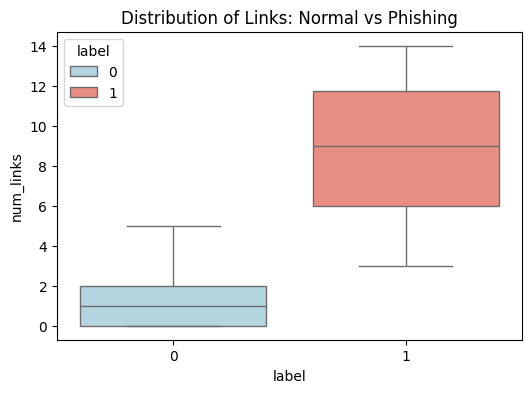

In [11]:
# Compare statistics side-by-side
print(df.groupby('label')['num_links'].describe())

# Visual proof: Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='label', y='num_links', hue='label', palette={'lightblue', 'salmon'})
plt.title("Distribution of Links: Normal vs Phishing")
plt.show()

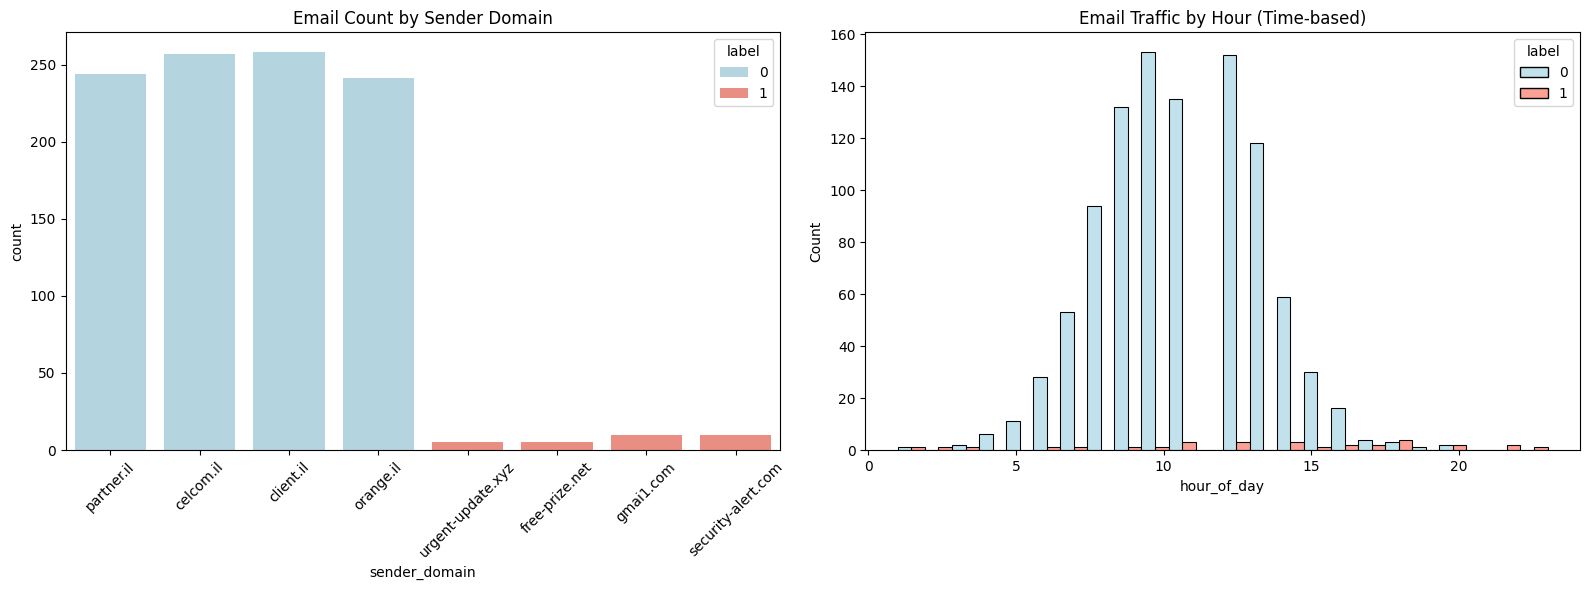

In [4]:
# --- Cell 3: Strict Assignment Visuals (EDA) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Countplot for Categorical Features (Sender Domain)
# This satisfies: "countplots for categorical features"
sns.countplot(
    data=df, 
    x='sender_domain', 
    hue='label', 
    palette=['lightblue', 'salmon'],
    ax=axes[0]
)
axes[0].set_title('Email Count by Sender Domain')
axes[0].tick_params(axis='x', rotation=45) # Rotate labels so they don't overlap

# 2. Time-based Distribution (Hour of Day)
# This satisfies: "time-based distribution (e.g., logins per hour)"
sns.histplot(
    data=df, 
    x='hour_of_day', 
    hue='label', 
    multiple='dodge', 
    bins=24, 
    palette=['lightblue', 'salmon'],
    ax=axes[1]
)
axes[1].set_title('Email Traffic by Hour (Time-based)')

plt.tight_layout()
plt.show()

In [9]:
print("The exploratory analysis reveals that 'Normal' traffic follows a strict pattern of standard business hours (06:00–15:00) and contains very few hyperlinks (typically 0–2 per email) originating from trusted local domains like celcom.il or partner.il. In contrast, the simulated Phishing attacks (T1566) display a chaotic timeline and a distinct numeric signature: they contain a significantly higher density of links (averaging >8) and originate from suspicious external domains. Based on this clear physical separation in the data, I expect the anomaly detection model to easily classify entries with high num_links values as anomalies, regardless of the time they were sent.")

The exploratory analysis reveals that 'Normal' traffic follows a strict pattern of standard business hours (06:00–15:00) and contains very few hyperlinks (typically 0–2 per email) originating from trusted local domains like celcom.il or partner.il. In contrast, the simulated Phishing attacks (T1566) display a chaotic timeline and a distinct numeric signature: they contain a significantly higher density of links (averaging >8) and originate from suspicious external domains. Based on this clear physical separation in the data, I expect the anomaly detection model to easily classify entries with high num_links values as anomalies, regardless of the time they were sent.


Training model...


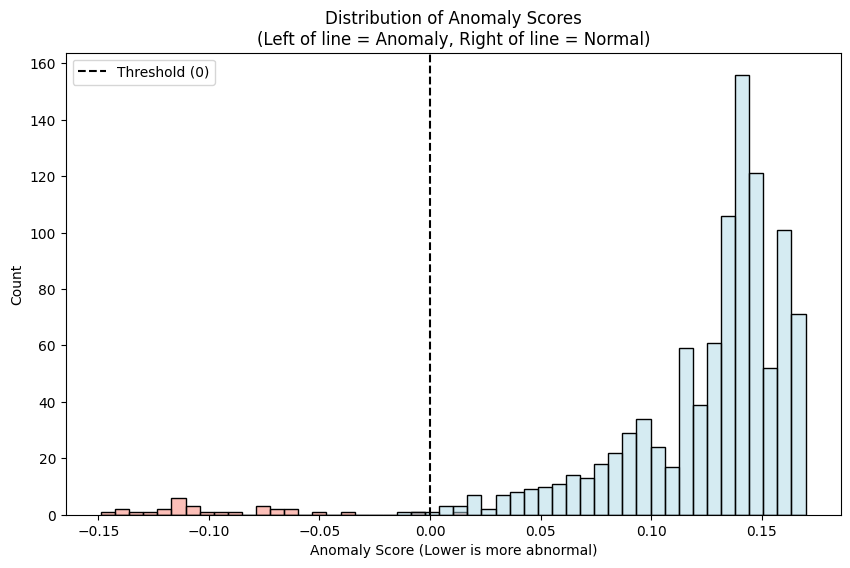


--- Detection Report ---
The model detected 31 anomalies out of 1030 total emails.

--- Classification Report ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
    Phishing       0.94      0.97      0.95        30

    accuracy                           1.00      1030
   macro avg       0.97      0.98      0.97      1030
weighted avg       1.00      1.00      1.00      1030



In [17]:
# --- Cell 4: Anomaly Detection (Isolation Forest) ---
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

# 1. Preprocessing Setup
# We need to transform our data so the model can read it
features = ['hour_of_day', 'num_links', 'sender_domain']
X = df[features]
y_true = df['label'] # We only use this to check our answers at the end

# Create a Transformer:
# - Scale numeric values (hour, links) so they are roughly -1 to 1
# - One-Hot Encode the domain (turn "gmail.com" into [0, 1, 0, ...])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['hour_of_day', 'num_links']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['sender_domain'])
    ])

# 2. Transform the Data
X_processed = preprocessor.fit_transform(X)

# 3. Train Isolation Forest
# n_estimators=200: Same as your example code
# contamination=0.03: We expect about 3% anomalies (30 out of 1000)
model = IsolationForest(n_estimators=200, contamination=0.03, random_state=42)
print("Training model...")
model.fit(X_processed)

# 4. Extract Predictions & Scores
# "decision_function" gives the anomaly score.
# Negative scores = Anomaly. Positive scores = Normal.
anomaly_scores = model.decision_function(X_processed)
raw_predictions = model.predict(X_processed) # Returns -1 for anomaly, 1 for normal

# Convert predictions to match our labels (0=Normal, 1=Phishing)
y_pred = [1 if x == -1 else 0 for x in raw_predictions]
df['pred_label'] = y_pred
df['anomaly_score'] = anomaly_scores

# 5. Evaluation (Assignment Requirements)

# A. Histogram of Anomaly Scores
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='anomaly_score', hue='label', palette=['lightblue', 'salmon'], bins=50)
plt.axvline(x=0, color='black', linestyle='--', label='Threshold (0)')
plt.title('Distribution of Anomaly Scores\n(Left of line = Anomaly, Right of line = Normal)')
plt.xlabel('Anomaly Score (Lower is more abnormal)')
plt.legend()
plt.show()

# B. Metrics
print("\n--- Detection Report ---")
n_detected = sum(y_pred)
print(f"The model detected {n_detected} anomalies out of {len(df)} total emails.")
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Phishing']))

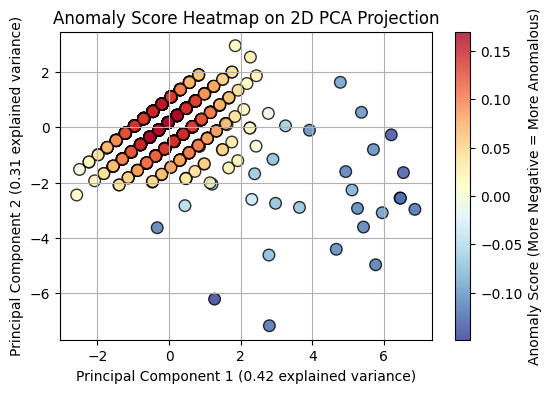

In [20]:
# --- Cell 5: Anomaly Score Heatmap on 2D PCA Projection ---
from sklearn.decomposition import PCA
import pandas as pd 

# NOTE: We assume X_processed, df['anomaly_score'], and df['pred_label'] 
# are available from Cell 4.

# 1. Apply Dimensionality Reduction (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# 2. Create Plotting DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['anomaly_score'] = df['anomaly_score']

# 3. Plotting the Heatmap Scatter Plot
plt.figure(figsize=(6, 4))

# Use plt.scatter directly to map the continuous score to color (c)
scatter = plt.scatter(
    x=pca_df['PC1'],
    y=pca_df['PC2'],
    c=pca_df['anomaly_score'],  # <--- The score determines the color intensity
    cmap='RdYlBu_r',            # <--- Colormap where Red = Hot (Anomalous)
    s=70, 
    edgecolor='k',
    alpha=0.8
)

# Add a color bar to show the "heat" legend
plt.colorbar(scatter, label='Anomaly Score (More Negative = More Anomalous)')

# Find the threshold score (closest to 0) for better context
# The points colored most intensely red are the worst offenders.

plt.title('Anomaly Score Heatmap on 2D PCA Projection')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2f} explained variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2f} explained variance)')
plt.grid(True)
plt.show()

In [22]:
print("The 2D PCA projection of the dataset successfully isolates the anomalies, revealing normal behavior as a dense cluster with positive scores (cool colors). Anomalies are clearly visible as isolated points on the periphery, highlighted by intensely negative scores (red/hot colors), confirming the model's excellent separation capability.")

The 2D PCA projection of the dataset successfully isolates the anomalies, revealing normal behavior as a dense cluster with positive scores (cool colors). Anomalies are clearly visible as isolated points on the periphery, highlighted by intensely negative scores (red/hot colors), confirming the model's excellent separation capability.


In [6]:
print("--------------------------------------------------------------------Conclusion-------------------------------------------------------------------------")
print("This project successfully established an end-to-end unsupervised anomaly detection pipeline for identifying simulated Phishing attacks (MITRE T1566) within email log data. The exploratory analysis confirmed that a strong anomaly signal exists, driven primarily by the difference between low num_links in normal traffic and the high link counts found in malicious emails.")

--------------------------------------------------------------------Conclusion-------------------------------------------------------------------------
This project successfully established an end-to-end unsupervised anomaly detection pipeline for identifying simulated Phishing attacks (MITRE T1566) within email log data. The exploratory analysis confirmed that a strong anomaly signal exists, driven primarily by the difference between low num_links in normal traffic and the high link counts found in malicious emails.
